In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import jax
from jax import random
from jax import numpy as jnp
import optax

from tqdm.auto import tqdm

from nested_resevoirs import nested_resevoirs
from nested_resevoirs import parameters
import data
# from nam_classic import defaults
# from nam_classic import parameters as nam_parameters

In [8]:
params = parameters.NRParameters.sample(random.key(41))
state = parameters.NRState(snow=jnp.array(1), surface=jnp.array(5), subsurface=jnp.array(25), groundwater=jnp.array(25000))
obs = nam_parameters.NAM_Observation(*[q[0] for q in defaults.default_observations])

In [9]:
sampled_params = [parameters.NRParameters.sample(random.key(i)) for i in range(100)]

In [10]:
predict_multiple = jax.vmap(nested_resevoirs.predict, in_axes=[0,0,None])
mse_multiple = jax.vmap(nested_resevoirs.mse, in_axes=[0,0,None,None])

def mse_multiple_sum(*args):
    return jnp.sum(mse_multiple(*args))

mse_multiple_grad = jax.grad(mse_multiple_sum, argnums=[0,1])

In [12]:
optimizer = optax.adam(learning_rate=1e-1)
optimizer_target = sampled_params.copy()
opt_state = optimizer.init(optimizer_target)

In [5]:
grads = mse_multiple_grad(
  {k:optimizer_target[k] for k in trainable_params_keys},
  {k:optimizer_target[k] for k in trainable_state_keys},
  fixed_params,
  fixed_state,
  defaults.default_observations,
  defaults.excel_results["qobs"].to_numpy()
)
grads = {**grads[0], **grads[1]}

In [7]:
mse_tracer = []
for _ in tqdm(list(range(80))):
    mse_current = mse_multiple(
        {k:optimizer_target[k] for k in trainable_params_keys},
        {k:optimizer_target[k] for k in trainable_state_keys},
        fixed_params,
        fixed_state,
        defaults.default_observations,
        defaults.excel_results["qobs"].to_numpy()
    )
    mse_tracer.append(mse_current)
    grads = mse_multiple_grad(
      {k:optimizer_target[k] for k in trainable_params_keys},
      {k:optimizer_target[k] for k in trainable_state_keys},
      fixed_params,
      fixed_state,
      defaults.default_observations,
      defaults.excel_results["qobs"].to_numpy()
    )
    grads = {**grads[0], **grads[1]}
    updates, opt_state = optimizer.update(grads, opt_state)
    optimizer_target = optax.apply_updates(optimizer_target, updates)

  0%|          | 0/80 [00:00<?, ?it/s]

In [8]:
mse_trace = jnp.stack(mse_tracer, axis=-1)

In [9]:
from matplotlib import pyplot as plt

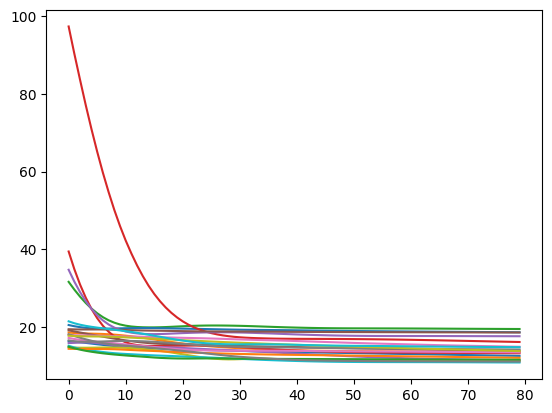

In [10]:
fig, ax = plt.subplots()
for i in range(20):
    ax.plot(mse_trace[i,:])

In [11]:
physical_params_final = parameters.to_physical(optimizer_target)

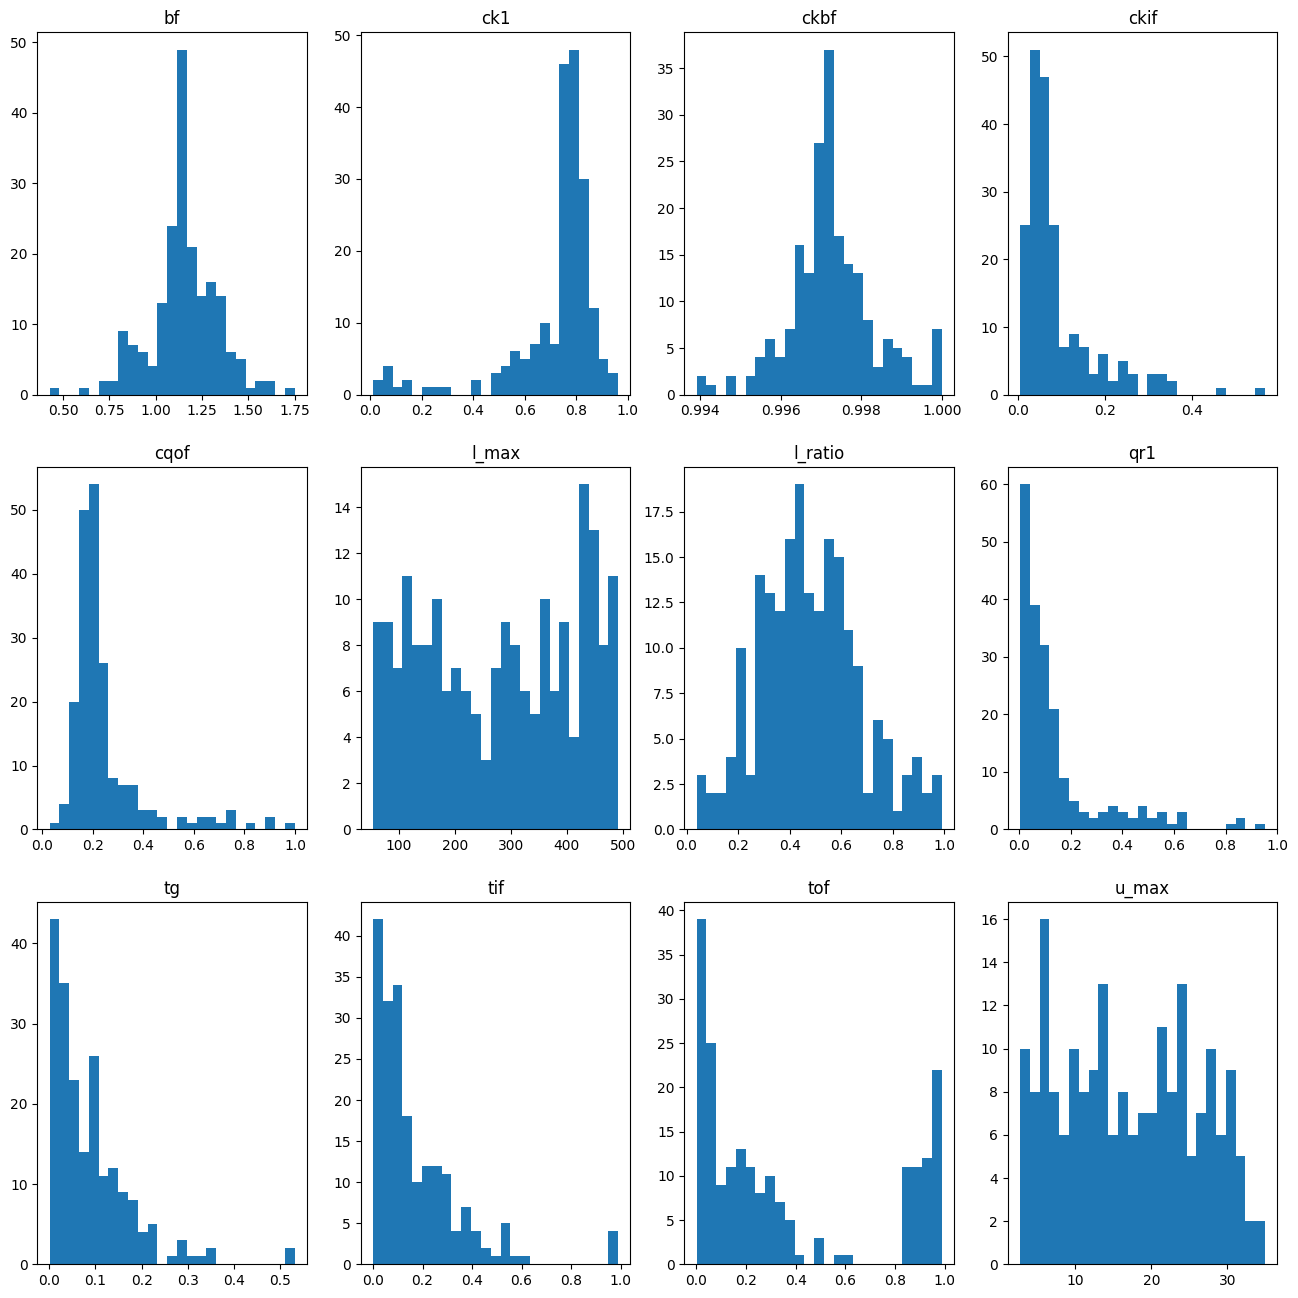

In [12]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16,16))
axf = axs.flatten()
for p,ax in zip(physical_params_final, axf):
    ax.hist(physical_params_final[p], bins=25)
    ax.set_title(p)

In [15]:
qmean = defaults.excel_results["qobs"].to_numpy().mean()

In [16]:
ssd0 = jnp.mean(jnp.square(qmean-defaults.excel_results["qobs"].to_numpy()))

In [20]:
mse_trace[jnp.argmin(mse_trace[:,-1]),-1]

Array(10.77126, dtype=float32)

In [19]:
{k: round(float(v[jnp.argmin(mse_trace[:,-1])]),3) for k,v in physical_params_final.items()}

{'bf': 1.109,
 'ck1': 0.787,
 'ckbf': 0.997,
 'ckif': 0.059,
 'cqof': 0.155,
 'l_max': 103.265,
 'l_ratio': 0.748,
 'qr1': 0.108,
 'tg': 0.29,
 'tif': 0.624,
 'tof': 0.078,
 'u_max': 7.786,
 'u_ratio': 0.992}

In [22]:
1-mse_trace[jnp.argmin(mse_trace[:,-1]),-1] / ssd0

Array(0.7799396, dtype=float32)

(array([ 3.,  0.,  2.,  5.,  8.,  5.,  6.,  8.,  4.,  1.,  3.,  7.,  3.,
         2.,  5.,  7., 10.,  7., 19.,  8., 10., 12., 15., 30., 20.]),
 array([0.56869775, 0.57714742, 0.5855971 , 0.59404677, 0.60249645,
        0.61094612, 0.61939579, 0.62784547, 0.63629514, 0.64474481,
        0.65319449, 0.66164416, 0.67009383, 0.67854351, 0.68699318,
        0.69544286, 0.70389253, 0.7123422 , 0.72079188, 0.72924155,
        0.73769122, 0.7461409 , 0.75459057, 0.76304024, 0.77148992,
        0.77993959]),
 <BarContainer object of 25 artists>)

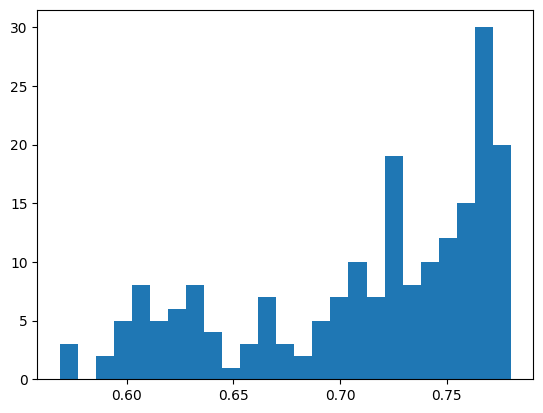

In [18]:
plt.hist(1 - mse_trace[:,-1] / ssd0, bins=25)